# Sensitivity Analysis: Impact of Input Variables on Black-Litterman Model

## 1. The Black-Litterman Model

The Black-Litterman (BL) (Black & Litterman, 1990, 1991 and 1992) model can mathematically represent a Bayesian update of the expected excess return  benchmark (prior) by active views from the portfolio manager (views). Black & Litterman believe in semi-strong market efficiency (Fama, 1970), which means that the market equilibrium of expected excess returns ($μ$) might not always be upheld. However, long-term, they would converge to the market-implied equilibrium returns ($Π$). Therefore, the expected excess returns can be written as:

$$μ^{prior}=Π+ε^{(i)}$$

$$ε^{(i)} \sim \mathcal{N}(0, τΣ)$$


where $Σ$ is the covariance matrix (n×n) of asset excess returns, $τ$ is a scalar representing the uncertainty in the prior, and $ε^{(i)}$ is the error term vector (n×1) of the implied returns with mean zero and $τΣ$ variance. 
The market implied equilibrium excess returns ($Π$) is such that assuming all investors hold the same view, the market would clear, i.e., the demand for these assets exactly equals the supply. Therefore:

$$Π=λΣw_{mkt}$$

where $λ$ is the risk aversion coefficient, and $w_{mkt}$ is the vector (n×1) of market capitalisation weights.

Leading to:

$$μ^{prior}\sim \mathcal{N}(Π, τΣ)$$

The model then combines these equilibrium excess returns with the investor's views to produce a posterior estimate of expected returns. Given that the views are also uncertain, these can be written as follows:

$$Pμ=Q+ε^{(v)}$$
$$ε^{(v)} \sim \mathcal{N}(0, Ω)$$

Therefore:

$$Pμ \sim \mathcal{N}(Q, Ω)$$

When combining prior with investor views:

$$μ^{posteriori}=E(R)=[(τΣ)^{-1}+P^T.Ω^{-1}.P]^{-1}  [(τΣ)^{-1}.Π+P^T.Ω^{-1}.Q]$$

where:

$$Ω = \begin{pmatrix}
ω_1 & ... & 0 \\
... & ... & ... \\
0 & ... & ω_k \\
\end{pmatrix}
$$

Therefore:

$$μ^{posteriori}\sim \mathcal{N}(E(R),[(τΣ)^{-1}+P^T Ω^{-1} P]^{-1})$$

where $E(R)$ is the vector (n×1) of the posterior estimates of expected excess returns, $P$ is a matrix (k×n) that identifies the assets involved in the k views, $Ω$ is the diagonal covariance matrix (k×k) of the views, $ω_k$ the error of the k view, $Q$ is a vector (k×1) of the investor's views, and $ε^{(v)}$ is the error term vector (k×1) for the views with mean zero and $Ω$ variance. If the investor has no views, then $μ^{priori}$ will be equal to $μ^{posteriori}$.

Black & Litterman then used the updated estimated of excess returns generated from the BL model as input to the traditional mean-variance optimisation (Markowitz, 1952), however, we will apply the traditional unconstrain quaddratic utility function.

$$w^*=argmax_w [{w^T.E(R)-\frac{1}{2}.λ.w^T.Σ.w}]$$


If the investor has no views, then $w^*$ will equal $w_{mkt}$. 

Despite the practicability of the BL model, this model is sensitive to inputs. Therefore, this research aims to discover the model's sensitivity to different inputs.

In [1]:
#Import dependencies
import pypfopt as pf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import math
import yfinance as yf
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import plotting
from pypfopt import objective_functions
import warnings
warnings.filterwarnings("ignore")

In [2]:
def BL_model(mcap_weights,E,ra,P,Q,tau,omega):
    #calculate implied:
    IR = np.array(ra*E@mcap_weights).reshape(len(mcap_weights),1)
    #calculate new expected excess returns
    ER = np.linalg.inv(np.linalg.inv(tau*E) + P.transpose()@np.linalg.inv(omega)@P) @ (np.linalg.inv(tau*E)@IR + P.transpose()@np.linalg.inv(omega)@Q)
    #calculate new variance
    Var = pd.DataFrame(np.linalg.inv(tau*np.linalg.inv(E) + P.transpose()@np.linalg.inv(omega)@P))
    #Var.set_index() = E.index()
    return ER

## 2. Data 

From the Refinitiv Database, we gather the monthly adjusted close of the 11 Sector ETFs of the US Stock Market from 2018-08-01 to 2023-12-01. We deducted the 1-month T-Bills return (our risk-free asset) to achieve our excess monthly returns.

In [3]:
data= pd.read_excel('Excess Montly Returns.xlsx', index_col='Date')

In [4]:
data.tail()

,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Date,,,,,,,,,,,
2023-08-01,-0.037552,-0.019947,0.011923,-0.031427,-0.024371,-0.019620,-0.044009,-0.035174,-0.065817,-0.011544,-0.021977
2023-09-01,-0.056892,-0.036425,0.011998,-0.039728,-0.067825,-0.071310,-0.058822,-0.084220,-0.068542,-0.038089,-0.061531
2023-10-01,-0.031674,-0.015142,-0.055215,-0.024700,-0.030478,-0.002017,-0.011764,-0.025367,0.016463,-0.033298,-0.058123
2023-11-01,0.079074,0.073616,-0.011573,0.104982,0.083936,0.124543,0.036849,0.120361,0.047020,0.049948,0.105252
2023-12-01,0.033393,0.036834,-0.013337,0.042766,0.060242,0.034946,0.014801,0.071427,0.004495,0.034023,0.054839


## 3. Black-Litterman with no views

In this section, we will study our benchmark, the Market Portfolio.

### 3.1. Composition

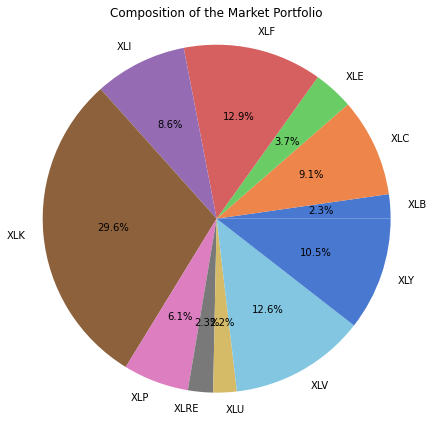

In [5]:
Cov_Matrix = data.cov()*12 #converting monthly covariance matrix to annual
Risk_Aversion = 2.5
tau = 0.05

#Market Cap Weights according to their % in relation to S&P500 (05/02/2024)
mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]

palette_color = sns.color_palette('muted') 
plt.pie(mcap_weights, labels=data.columns, colors=palette_color, autopct='%.1f%%',normalize=False,radius=2) 
plt.title('Composition of the Market Portfolio', y=1.4)
plt.show()

### 3.2. The annual Correlation and Covariance Matrix of Excess Returns

In [6]:
data.corr()

,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
XLB,1.000000,0.774893,0.656998,0.860081,0.909469,0.754999,0.763861,0.789523,0.621476,0.777628,0.811598
XLC,0.774893,1.000000,0.543167,0.776309,0.783470,0.858844,0.613592,0.735391,0.506587,0.632687,0.830077
XLE,0.656998,0.543167,1.000000,0.761753,0.689708,0.472184,0.498817,0.454349,0.316792,0.523082,0.518109
XLF,0.860081,0.776309,0.761753,1.000000,0.900322,0.692117,0.681372,0.721386,0.512176,0.671071,0.734321
XLI,0.909469,0.783470,0.689708,0.900322,1.000000,0.790956,0.772229,0.763612,0.582772,0.763974,0.803464
XLK,0.754999,0.858844,0.472184,0.692117,0.790956,1.000000,0.639224,0.717341,0.489201,0.675126,0.892708
XLP,0.763861,0.613592,0.498817,0.681372,0.772229,0.639224,1.000000,0.748384,0.733855,0.751791,0.593157
XLRE,0.789523,0.735391,0.454349,0.721386,0.763612,0.717341,0.748384,1.000000,0.725705,0.711488,0.794109
XLU,0.621476,0.506587,0.316792,0.512176,0.582772,0.489201,0.733855,0.725705,1.000000,0.600790,0.496856
XLV,0.777628,0.632687,0.523082,0.671071,0.763974,0.675126,0.751791,0.711488,0.600790,1.000000,0.670797


In [7]:
Cov_Matrix

,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
XLB,0.050935,0.037306,0.056420,0.045993,0.046881,0.039258,0.025606,0.036902,0.024126,0.028124,0.045254
XLC,0.037306,0.045505,0.044089,0.039238,0.038173,0.042211,0.019442,0.032488,0.018589,0.021628,0.043748
XLE,0.056420,0.044089,0.144786,0.068678,0.059942,0.041395,0.028192,0.035804,0.020735,0.031895,0.048707
XLF,0.045993,0.039238,0.068678,0.056142,0.048724,0.037783,0.023980,0.035398,0.020875,0.025480,0.042987
XLI,0.046881,0.038173,0.059942,0.048724,0.052168,0.041623,0.026198,0.036120,0.022896,0.027963,0.045339
XLK,0.039258,0.042211,0.041395,0.037783,0.041623,0.053083,0.021875,0.034228,0.019388,0.024926,0.050815
XLP,0.025606,0.019442,0.028192,0.023980,0.026198,0.021875,0.022062,0.023021,0.018750,0.017895,0.021767
XLRE,0.036902,0.032488,0.035804,0.035398,0.036120,0.034228,0.023021,0.042889,0.025852,0.023612,0.040631
XLU,0.024126,0.018589,0.020735,0.020875,0.022896,0.019388,0.018750,0.025852,0.029588,0.016561,0.021115
XLV,0.028124,0.021628,0.031895,0.025480,0.027963,0.024926,0.017895,0.023612,0.016561,0.025680,0.026558


### 3.3. Implied Market Returns

In [8]:
Implied_Returns = np.array(Risk_Aversion*Cov_Matrix@mcap_weights).reshape(len(mcap_weights),1)
Risk_Aversion*Cov_Matrix@mcap_weights

XLB     0.098786
XLC     0.092935
XLE     0.122817
XLF     0.100724
XLI     0.102800
XLK     0.103782
XLP     0.055179
XLRE    0.082927
XLU     0.050311
XLV     0.062284
XLY     0.109604
dtype: float64

### 3.4. Efficient Frontier

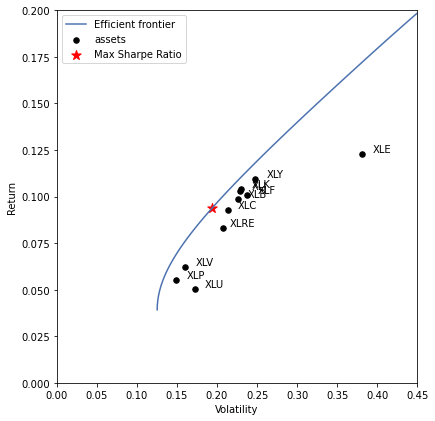

In [9]:
ef = EfficientFrontier(Implied_Returns, Cov_Matrix, weight_bounds=(None, None))
ef_max_sharpe = ef.deepcopy()
ef_max_quadratic = ef.deepcopy()
fig, ax = plt.subplots(figsize=(15/2.54, 15/2.54))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True,show_tickers=False)
plt.xlim(0,0.45)
plt.ylim(0,0.2)
for i in range(len(data.columns)):
    ax.annotate(data.columns[i], xy=(Cov_Matrix.iloc[i,i]**.5, Implied_Returns[i]), xytext=(20,0), 
            textcoords='offset points', ha='center', va='bottom')
ef_max_sharpe.max_sharpe(risk_free_rate=0)
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance(risk_free_rate=0)
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe Ratio")
ax.legend()
plt.show()

## 4. Sensitivity Analysis

In this section, we will perform a sensitivity analysis for different inputs.
For all cases, our benchmark inputs are:

$τ = 0.05$

$λ = 2.5$

$Σ$ as stated in 3.2 (historical).

$w_{mkt}$ as stated in 3.1.

As the higher proportion of market share is attributed to XLK, it will be easier to read any changes in the portfolio allocation percentage. It has weight of 29.6% and an implied return of 13.38%.

### 4.1. Single absolute view

For our analysis we will start to have only one absolute view ($A_1$): "We expect that XLK will have an excess return of 15%. This view has a 0.1 variance of error."

Therefore:

$$P =  \begin{pmatrix}
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0
\end{pmatrix}$$

$$Q = \begin{pmatrix}
0.15
\end{pmatrix}$$

$$Ω = \begin{pmatrix}
0.1
\end{pmatrix}$$

In [10]:
#baseline model for single absolute view
P = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])
Q = np.array([[0.15]])
Omega = np.array([[0.1]])
tau = 0.05
Risk_Aversion = 2.5
Cov_Matrix = data.cov()*12
mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]

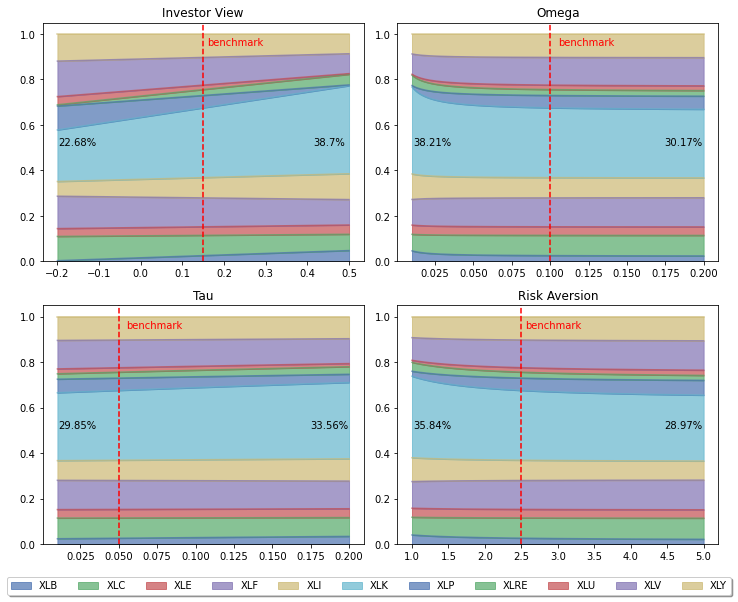

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

#Investor View
output = pd.DataFrame()

for i in np.linspace(-.2, 0.5, 201):
    P = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])
    Q = np.array([[i]])
    Omega = np.array([[0.1]])
    tau = 0.05
    Risk_Aversion = 2.5
    Cov_Matrix = data.cov()*12
    mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]
    a = BL_model(mcap_weights,Cov_Matrix,Risk_Aversion,P,Q,tau,Omega)
    ef = EfficientFrontier(a, Cov_Matrix, weight_bounds=(None, None))
    output = pd.concat([output, pd.DataFrame(list(ef.max_quadratic_utility(risk_aversion=Risk_Aversion).values())).transpose()], ignore_index=True)
output = output.set_axis(data.columns, axis=1)
output = output.set_axis(np.linspace(-.2, 0.5, 201), axis=0)

output.plot(kind='area', stacked=True,alpha=0.7, ax=axes[0,0])

axes[0,0].annotate(str(round(output.iloc[0,5]*100,2))+"%", xy=(-.2, 0.5),xytext=(20,0),
            textcoords='offset points', ha='center', va='bottom')
axes[0,0].annotate(str(round(output.iloc[-1,5]*100,2))+"%", xy=(0.5, 0.5),xytext=(-20,0),
            textcoords='offset points', ha='center', va='bottom')

axes[0,0].axvline(x=0.15, color='r', linestyle='--')
axes[0,0].annotate('benchmark', xy=(0.15, 0.95), xytext=(0.16, 0.95), color='r')
axes[0,0].legend().remove()
axes[0,0].set_title("Investor View")


#Omega
output = pd.DataFrame()

for i in np.linspace(0.01, 0.2, 200):
    P = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])
    Q = np.array([[0.15]])
    Omega = np.array([[i]])
    tau = 0.05
    Risk_Aversion = 2.5
    Cov_Matrix = data.cov()*12
    mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]
    a = BL_model(mcap_weights,Cov_Matrix,Risk_Aversion,P,Q,tau,Omega)
    ef = EfficientFrontier(a, Cov_Matrix, weight_bounds=(None, None))
    output = pd.concat([output, pd.DataFrame(list(ef.max_quadratic_utility(risk_aversion=Risk_Aversion).values())).transpose()], ignore_index=True)
output = output.set_axis(data.columns, axis=1)
output = output.set_axis(np.linspace(0.01, 0.2, 200), axis=0)
output.plot(kind='area', stacked=True,alpha=0.7, ax=axes[0,1])

axes[0,1].annotate(str(round(output.iloc[0,5]*100,2))+"%", xy=(0.01, 0.5),xytext=(20,0),
            textcoords='offset points', ha='center', va='bottom')
axes[0,1].annotate(str(round(output.iloc[-1,5]*100,2))+"%", xy=(0.2, 0.5),xytext=(-20,0),
            textcoords='offset points', ha='center', va='bottom')

axes[0,1].axvline(x=0.1, color='r', linestyle='--')
axes[0,1].annotate('benchmark', xy=(Implied_Returns[5][0], 0.95), xytext=(0.105, 0.95),color='r')
axes[0,1].legend().remove()
axes[0,1].set_title("Omega")

#tau
output = pd.DataFrame()

for i in np.linspace(0.01, 0.2, 200):
    P = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])
    Q = np.array([[0.15]])
    Omega = np.array([[0.1]])
    tau = i
    Risk_Aversion = 2.5
    Cov_Matrix = data.cov()*12
    mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]
    a = BL_model(mcap_weights,Cov_Matrix,Risk_Aversion,P,Q,tau,Omega)
    ef = EfficientFrontier(a, Cov_Matrix, weight_bounds=(None, None))
    output = pd.concat([output, pd.DataFrame(list(ef.max_quadratic_utility(risk_aversion=Risk_Aversion).values())).transpose()], ignore_index=True)
output = output.set_axis(data.columns, axis=1)
output = output.set_axis(np.linspace(0.01, 0.2, 200), axis=0)
output.plot(kind='area', stacked=True,alpha=0.7, ax=axes[1,0])

axes[1,0].annotate(str(round(output.iloc[0,5]*100,2))+"%", xy=(0.01, 0.5),xytext=(20,0),
            textcoords='offset points', ha='center', va='bottom')
axes[1,0].annotate(str(round(output.iloc[-1,5]*100,2))+"%", xy=(0.2, 0.5),xytext=(-20,0),
            textcoords='offset points', ha='center', va='bottom')

axes[1,0].axvline(x=0.05, color='r', linestyle='--')
axes[1,0].annotate('benchmark', xy=(0.05, 0.95), xytext=(0.055, 0.95),color='r')
axes[1,0].set_title("Tau")
axes[1,0].legend().remove()

#Risk Aversion
output = pd.DataFrame()

for i in np.linspace(1, 5, 200):
    P = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])
    Q = np.array([[0.15]])
    Omega = np.array([[0.1]])
    tau = 0.05
    Risk_Aversion = i
    Cov_Matrix = data.cov()*12
    mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]
    a = BL_model(mcap_weights,Cov_Matrix,Risk_Aversion,P,Q,tau,Omega)
    ef = EfficientFrontier(a, Cov_Matrix, weight_bounds=(None, None))
    output = pd.concat([output, pd.DataFrame(list(ef.max_quadratic_utility(risk_aversion=Risk_Aversion).values())).transpose()], ignore_index=True)
output = output.set_axis(data.columns, axis=1)
output = output.set_axis(np.linspace(1, 5, 200), axis=0)
output.plot(kind='area', stacked=True,alpha=0.7, ax=axes[1,1])

axes[1,1].annotate(str(round(output.iloc[0,5]*100,2))+"%", xy=(1, 0.5),xytext=(20,0),
            textcoords='offset points', ha='center', va='bottom')
axes[1,1].annotate(str(round(output.iloc[-1,5]*100,2))+"%", xy=(5, 0.5),xytext=(-20,0),
            textcoords='offset points', ha='center', va='bottom')

axes[1,1].axvline(x=2.5, color='r', linestyle='--')
axes[1,1].annotate('benchmark', xy=(2.5, 0.95), xytext=(2.55, 0.95),color='r')

axes[1,1].legend().remove()
axes[1,1].set_title("Risk Aversion")


#legends
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,0), shadow=True, ncol=11)
# Adjust layout
plt.tight_layout()
plt.show()


This figure shows us the percentage at the lowest and highest value for XLK in the BL optimization. We can see that the sensitivity is high and nonlinear for low values of $ω_1$. Although it has the widest range, the investor views have an impactful change in the optimal weights. This relationship is linear.

### 4.2. Two Absolute Views

We will add a second absolute view ($A_2$): "We expect that XLP will have an excess return of 10%. This view has a 0.15 variance of error."
Adding to the previous we will have:

$$P =  \begin{pmatrix}
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0
\end{pmatrix}$$

$$Q = \begin{pmatrix}
0.15\\
0.1
\end{pmatrix}$$

$$Ω = \begin{pmatrix}
0.1 & 0\\
0 & 0.15
\end{pmatrix}$$

In [12]:
#baseline model for two absolute views
P = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])
Q = np.array([[0.15],[0.1]])
Omega = np.array([[0.1,0],[0,0.15]])
tau = 0.05
Risk_Aversion = 2.5
Cov_Matrix = data.cov()*12
mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]

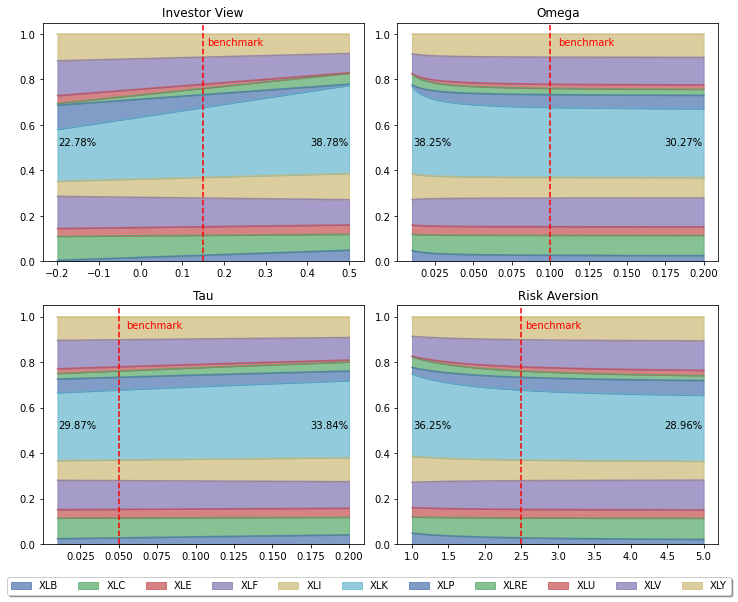

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

#Investor View
output = pd.DataFrame()

for i in np.linspace(-.2, 0.5, 201):
    P = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])
    Q = np.array([[i],[0.1]])
    Omega = np.array([[0.1,0],[0,0.15]])
    tau = 0.05
    Risk_Aversion = 2.5
    Cov_Matrix = data.cov()*12
    mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]
    a = BL_model(mcap_weights,Cov_Matrix,Risk_Aversion,P,Q,tau,Omega)
    ef = EfficientFrontier(a, Cov_Matrix, weight_bounds=(None, None))
    output = pd.concat([output, pd.DataFrame(list(ef.max_quadratic_utility(risk_aversion=Risk_Aversion).values())).transpose()], ignore_index=True)
output = output.set_axis(data.columns, axis=1)
output = output.set_axis(np.linspace(-.2, 0.5, 201), axis=0)

output.plot(kind='area', stacked=True,alpha=0.7, ax=axes[0,0])

axes[0,0].annotate(str(round(output.iloc[0,5]*100,2))+"%", xy=(-.2, 0.5),xytext=(20,0),
            textcoords='offset points', ha='center', va='bottom')
axes[0,0].annotate(str(round(output.iloc[-1,5]*100,2))+"%", xy=(0.5, 0.5),xytext=(-20,0),
            textcoords='offset points', ha='center', va='bottom')

axes[0,0].axvline(x=0.15, color='r', linestyle='--')
axes[0,0].annotate('benchmark', xy=(0.15, 0.95), xytext=(0.16, 0.95), color='r')
axes[0,0].legend().remove()
axes[0,0].set_title("Investor View")


#Omega
output = pd.DataFrame()

for i in np.linspace(0.01, 0.2, 200):
    P = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])
    Q = np.array([[0.15],[0.1]])
    Omega = np.array([[i,0],[0,0.15]])
    tau = 0.05
    Risk_Aversion = 2.5
    Cov_Matrix = data.cov()*12
    mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]
    a = BL_model(mcap_weights,Cov_Matrix,Risk_Aversion,P,Q,tau,Omega)
    ef = EfficientFrontier(a, Cov_Matrix, weight_bounds=(None, None))
    output = pd.concat([output, pd.DataFrame(list(ef.max_quadratic_utility(risk_aversion=Risk_Aversion).values())).transpose()], ignore_index=True)
output = output.set_axis(data.columns, axis=1)
output = output.set_axis(np.linspace(0.01, 0.2, 200), axis=0)
output.plot(kind='area', stacked=True,alpha=0.7, ax=axes[0,1])

axes[0,1].annotate(str(round(output.iloc[0,5]*100,2))+"%", xy=(0.01, 0.5),xytext=(20,0),
            textcoords='offset points', ha='center', va='bottom')
axes[0,1].annotate(str(round(output.iloc[-1,5]*100,2))+"%", xy=(0.2, 0.5),xytext=(-20,0),
            textcoords='offset points', ha='center', va='bottom')

axes[0,1].axvline(x=0.1, color='r', linestyle='--')
axes[0,1].annotate('benchmark', xy=(Implied_Returns[5][0], 0.95), xytext=(0.105, 0.95),color='r')
axes[0,1].legend().remove()
axes[0,1].set_title("Omega")

#tau
output = pd.DataFrame()

for i in np.linspace(0.01, 0.2, 200):
    P = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])
    Q = np.array([[0.15],[0.1]])
    Omega = np.array([[0.1,0],[0,0.15]])
    tau = i
    Risk_Aversion = 2.5
    Cov_Matrix = data.cov()*12
    mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]
    a = BL_model(mcap_weights,Cov_Matrix,Risk_Aversion,P,Q,tau,Omega)
    ef = EfficientFrontier(a, Cov_Matrix, weight_bounds=(None, None))
    output = pd.concat([output, pd.DataFrame(list(ef.max_quadratic_utility(risk_aversion=Risk_Aversion).values())).transpose()], ignore_index=True)
output = output.set_axis(data.columns, axis=1)
output = output.set_axis(np.linspace(0.01, 0.2, 200), axis=0)
output.plot(kind='area', stacked=True,alpha=0.7, ax=axes[1,0])

axes[1,0].annotate(str(round(output.iloc[0,5]*100,2))+"%", xy=(0.01, 0.5),xytext=(20,0),
            textcoords='offset points', ha='center', va='bottom')
axes[1,0].annotate(str(round(output.iloc[-1,5]*100,2))+"%", xy=(0.2, 0.5),xytext=(-20,0),
            textcoords='offset points', ha='center', va='bottom')

axes[1,0].axvline(x=0.05, color='r', linestyle='--')
axes[1,0].annotate('benchmark', xy=(0.05, 0.95), xytext=(0.055, 0.95),color='r')
axes[1,0].set_title("Tau")
axes[1,0].legend().remove()

#Risk Aversion
output = pd.DataFrame()

for i in np.linspace(1, 5, 200):
    P = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])
    Q = np.array([[0.15],[0.1]])
    Omega = np.array([[0.1,0],[0,0.15]])
    tau = 0.05
    Risk_Aversion = i
    Cov_Matrix = data.cov()*12
    mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]
    a = BL_model(mcap_weights,Cov_Matrix,Risk_Aversion,P,Q,tau,Omega)
    ef = EfficientFrontier(a, Cov_Matrix, weight_bounds=(None, None))
    output = pd.concat([output, pd.DataFrame(list(ef.max_quadratic_utility(risk_aversion=Risk_Aversion).values())).transpose()], ignore_index=True)
output = output.set_axis(data.columns, axis=1)
output = output.set_axis(np.linspace(1, 5, 200), axis=0)
output.plot(kind='area', stacked=True,alpha=0.7, ax=axes[1,1])

axes[1,1].annotate(str(round(output.iloc[0,5]*100,2))+"%", xy=(1, 0.5),xytext=(20,0),
            textcoords='offset points', ha='center', va='bottom')
axes[1,1].annotate(str(round(output.iloc[-1,5]*100,2))+"%", xy=(5, 0.5),xytext=(-20,0),
            textcoords='offset points', ha='center', va='bottom')

axes[1,1].axvline(x=2.5, color='r', linestyle='--')
axes[1,1].annotate('benchmark', xy=(2.5, 0.95), xytext=(2.55, 0.95),color='r')

axes[1,1].legend().remove()
axes[1,1].set_title("Risk Aversion")


#legends
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,0), shadow=True, ncol=11)

# Adjust layout
plt.tight_layout()
plt.show()


By adding an extra absolute view, the conclusion does not change. We have more sensitivity from the investor's views, which is explained by the positive correlation for these two assets (0.639224).

### 4.3. One relative view

For the relative view ($R_1$): "We expect that XLK will outperform XLP for 10%. This view has a 0.1 variance of error." Our benchmark on this view was: 4.86%.

Therefore:

$$P =  \begin{pmatrix}
0 & 0 & 0 & 0 & 0 & 1 & -1 & 0 & 0 & 0 & 0
\end{pmatrix}$$

$$Q = \begin{pmatrix}
0.10
\end{pmatrix}$$

$$Ω = \begin{pmatrix}
0.1
\end{pmatrix}$$

In [14]:
#baseline model for 1 relative views
P = np.array([[0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0]])
Q = np.array([[0.10]])
Omega = np.array([[0.1]])
tau = 0.05
Risk_Aversion = 2.5
Cov_Matrix = data.cov()*12
mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]

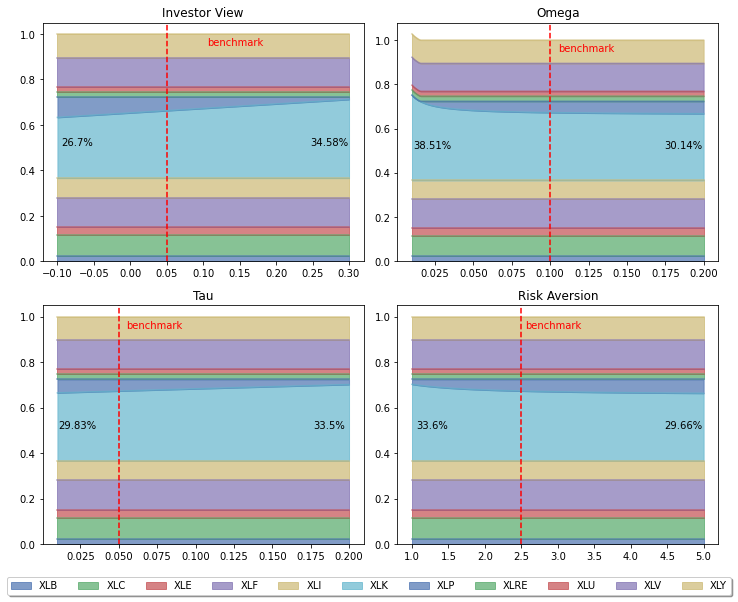

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

#Investor View
output = pd.DataFrame()

for i in np.linspace(-.1, 0.3, 201):
    P = np.array([[0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0]])
    Q = np.array([[i]])
    Omega = np.array([[0.1]])
    tau = 0.05
    Risk_Aversion = 2.5
    Cov_Matrix = data.cov()*12
    mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]
    a = BL_model(mcap_weights,Cov_Matrix,Risk_Aversion,P,Q,tau,Omega)
    ef = EfficientFrontier(a, Cov_Matrix, weight_bounds=(None, None))
    output = pd.concat([output, pd.DataFrame(list(ef.max_quadratic_utility(risk_aversion=Risk_Aversion).values())).transpose()], ignore_index=True)
output = output.set_axis(data.columns, axis=1)
output = output.set_axis(np.linspace(-.1, 0.3, 201), axis=0)

output.plot(kind='area', stacked=True,alpha=0.7, ax=axes[0,0])

axes[0,0].annotate(str(round(output.iloc[0,5]*100,2))+"%", xy=(-.1, 0.5),xytext=(20,0),
            textcoords='offset points', ha='center', va='bottom')
axes[0,0].annotate(str(round(output.iloc[-1,5]*100,2))+"%", xy=(0.3, 0.5),xytext=(-20,0),
            textcoords='offset points', ha='center', va='bottom')

axes[0,0].axvline(x=0.05, color='r', linestyle='--')
axes[0,0].annotate('benchmark', xy=(0.1, 0.95), xytext=(0.105, 0.95), color='r')
axes[0,0].legend().remove()
axes[0,0].set_title("Investor View")


#Omega
output = pd.DataFrame()

for i in np.linspace(0.01, 0.2, 200):
    P = np.array([[0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0]])
    Q = np.array([[0.1]])
    Omega = np.array([[i]])
    tau = 0.05
    Risk_Aversion = 2.5
    Cov_Matrix = data.cov()*12
    mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]
    a = BL_model(mcap_weights,Cov_Matrix,Risk_Aversion,P,Q,tau,Omega)
    ef = EfficientFrontier(a, Cov_Matrix, weight_bounds=(None, None))
    output = pd.concat([output, pd.DataFrame(list(ef.max_quadratic_utility(risk_aversion=Risk_Aversion).values())).transpose()], ignore_index=True)
output = output.set_axis(data.columns, axis=1)
output = output.set_axis(np.linspace(0.01, 0.2, 200), axis=0)
output = output.clip(lower=0)
output.plot(kind='area', stacked=True,alpha=0.7, ax=axes[0,1])

axes[0,1].annotate(str(round(output.iloc[0,5]*100,2))+"%", xy=(0.01, 0.5),xytext=(20,0),
            textcoords='offset points', ha='center', va='bottom')
axes[0,1].annotate(str(round(output.iloc[-1,5]*100,2))+"%", xy=(0.2, 0.5),xytext=(-20,0),
            textcoords='offset points', ha='center', va='bottom')

axes[0,1].axvline(x=0.1, color='r', linestyle='--')
axes[0,1].annotate('benchmark', xy=(Implied_Returns[5][0], 0.95), xytext=(0.105, 0.95),color='r')
axes[0,1].legend().remove()
axes[0,1].set_title("Omega")

#tau
output = pd.DataFrame()

for i in np.linspace(0.01, 0.2, 200):
    P = np.array([[0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0]])
    Q = np.array([[0.1]])
    Omega = np.array([[0.1]])
    tau = i
    Risk_Aversion = 2.5
    Cov_Matrix = data.cov()*12
    mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]
    a = BL_model(mcap_weights,Cov_Matrix,Risk_Aversion,P,Q,tau,Omega)
    ef = EfficientFrontier(a, Cov_Matrix, weight_bounds=(None, None))
    output = pd.concat([output, pd.DataFrame(list(ef.max_quadratic_utility(risk_aversion=Risk_Aversion).values())).transpose()], ignore_index=True)
output = output.set_axis(data.columns, axis=1)
output = output.set_axis(np.linspace(0.01, 0.2, 200), axis=0)
output.plot(kind='area', stacked=True,alpha=0.7, ax=axes[1,0])

axes[1,0].annotate(str(round(output.iloc[0,5]*100,2))+"%", xy=(0.01, 0.5),xytext=(20,0),
            textcoords='offset points', ha='center', va='bottom')
axes[1,0].annotate(str(round(output.iloc[-1,5]*100,2))+"%", xy=(0.2, 0.5),xytext=(-20,0),
            textcoords='offset points', ha='center', va='bottom')

axes[1,0].axvline(x=0.05, color='r', linestyle='--')
axes[1,0].annotate('benchmark', xy=(0.05, 0.95), xytext=(0.055, 0.95),color='r')
axes[1,0].set_title("Tau")
axes[1,0].legend().remove()

#Risk Aversion
output = pd.DataFrame()

for i in np.linspace(1, 5, 200):
    P = np.array([[0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0]])
    Q = np.array([[0.1]])
    Omega = np.array([[0.1]])
    tau = 0.05
    Risk_Aversion = i
    Cov_Matrix = data.cov()*12
    mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]
    a = BL_model(mcap_weights,Cov_Matrix,Risk_Aversion,P,Q,tau,Omega)
    ef = EfficientFrontier(a, Cov_Matrix, weight_bounds=(None, None))
    output = pd.concat([output, pd.DataFrame(list(ef.max_quadratic_utility(risk_aversion=Risk_Aversion).values())).transpose()], ignore_index=True)
output = output.set_axis(data.columns, axis=1)
output = output.set_axis(np.linspace(1, 5, 200), axis=0)
output.plot(kind='area', stacked=True,alpha=0.7, ax=axes[1,1])

axes[1,1].annotate(str(round(output.iloc[0,5]*100,2))+"%", xy=(1, 0.5),xytext=(20,0),
            textcoords='offset points', ha='center', va='bottom')
axes[1,1].annotate(str(round(output.iloc[-1,5]*100,2))+"%", xy=(5, 0.5),xytext=(-20,0),
            textcoords='offset points', ha='center', va='bottom')

axes[1,1].axvline(x=2.5, color='r', linestyle='--')
axes[1,1].annotate('benchmark', xy=(2.5, 0.95), xytext=(2.55, 0.95),color='r')

axes[1,1].legend().remove()
axes[1,1].set_title("Risk Aversion")


#legends
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,0), shadow=True, ncol=11)

# Adjust layout
plt.tight_layout()
plt.show()


Please note that the values above 1 in the Omega graph represent the shorting position needed on XLP, as this is an unconstrained portfolio optimization. Results are consistent with the previous. However, they are more sensitive to $τ$. This increases the relevance of having a more accurate $τ$ calculation when relative views are present.

### 4.4. Two Relative Views

We added a second relative view ($R_2$): "We expect that XLE will outperform XLP and XLU for 3%. This view has a 0.15 variance of error." Our benchmark on this view was: 7.07%.

Therefore:

$$P =  \begin{pmatrix}
0 & 0 & 0 & 0 & 0 & 1 & -1 & 0 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0 & 0 & -0.5 & 0 & -0.5 & 0 & 0
\end{pmatrix}$$

$$Q = \begin{pmatrix}
0.10\\
0.03
\end{pmatrix}$$

$$Ω = \begin{pmatrix}
0.1 & 0 \\
0 & 0.15\\
\end{pmatrix}$$

In [16]:
#baseline model for two relative views
P = np.array([[0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0, -0.5, 0, -0.5, 0, 0]])
Q = np.array([[0.1],[0.03]])
Omega = np.array([[0.1,0],[0,0.15]])
tau = 0.05
Risk_Aversion = 2.5
Cov_Matrix = data.cov()*12
mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]

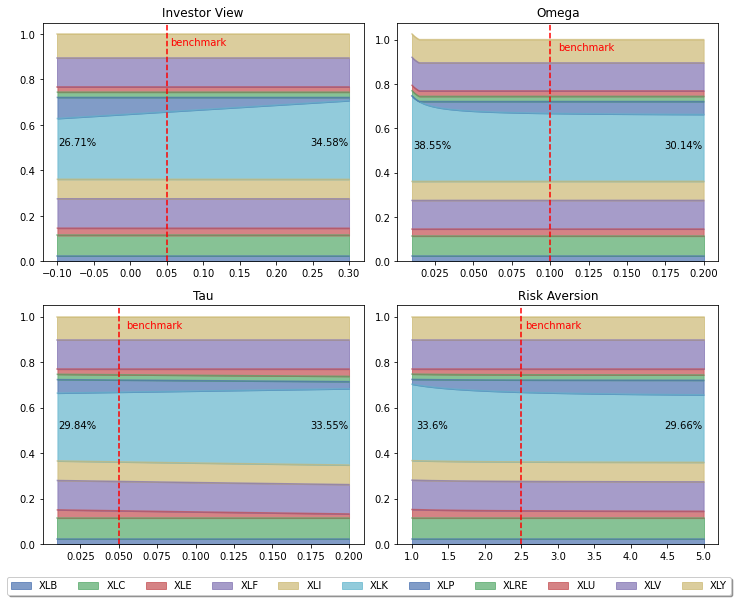

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

#Investor View
output = pd.DataFrame()

for i in np.linspace(-.1, 0.3, 201):
    P = np.array([[0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0, -0.5, 0, -0.5, 0, 0]])
    Q = np.array([[i],[0.03]])
    Omega = np.array([[0.1,0],[0,0.15]])
    tau = 0.05
    Risk_Aversion = 2.5
    Cov_Matrix = data.cov()*12
    mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]
    a = BL_model(mcap_weights,Cov_Matrix,Risk_Aversion,P,Q,tau,Omega)
    ef = EfficientFrontier(a, Cov_Matrix, weight_bounds=(None, None))
    output = pd.concat([output, pd.DataFrame(list(ef.max_quadratic_utility(risk_aversion=Risk_Aversion).values())).transpose()], ignore_index=True)
output = output.set_axis(data.columns, axis=1)
output = output.set_axis(np.linspace(-.1, 0.3, 201), axis=0)

output.plot(kind='area', stacked=True,alpha=0.7, ax=axes[0,0])

axes[0,0].annotate(str(round(output.iloc[0,5]*100,2))+"%", xy=(-.1, 0.5),xytext=(20,0),
            textcoords='offset points', ha='center', va='bottom')
axes[0,0].annotate(str(round(output.iloc[-1,5]*100,2))+"%", xy=(0.3, 0.5),xytext=(-20,0),
            textcoords='offset points', ha='center', va='bottom')

axes[0,0].axvline(x=0.05, color='r', linestyle='--')
axes[0,0].annotate('benchmark', xy=(0.05, 0.95), xytext=(0.055, 0.95), color='r')
axes[0,0].legend().remove()
axes[0,0].set_title("Investor View")


#Omega
output = pd.DataFrame()

for i in np.linspace(0.01, 0.2, 200):
    P = np.array([[0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0, -0.5, 0, -0.5, 0, 0]])
    Q = np.array([[0.1],[0.03]])
    Omega = np.array([[i,0],[0,0.15]])
    tau = 0.05
    Risk_Aversion = 2.5
    Cov_Matrix = data.cov()*12
    mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]
    a = BL_model(mcap_weights,Cov_Matrix,Risk_Aversion,P,Q,tau,Omega)
    ef = EfficientFrontier(a, Cov_Matrix, weight_bounds=(None, None))
    output = pd.concat([output, pd.DataFrame(list(ef.max_quadratic_utility(risk_aversion=Risk_Aversion).values())).transpose()], ignore_index=True)
output = output.set_axis(data.columns, axis=1)
output = output.set_axis(np.linspace(0.01, 0.2, 200), axis=0)
output = output.clip(lower=0)
output.plot(kind='area', stacked=True,alpha=0.7, ax=axes[0,1])

axes[0,1].annotate(str(round(output.iloc[0,5]*100,2))+"%", xy=(0.01, 0.5),xytext=(20,0),
            textcoords='offset points', ha='center', va='bottom')
axes[0,1].annotate(str(round(output.iloc[-1,5]*100,2))+"%", xy=(0.2, 0.5),xytext=(-20,0),
            textcoords='offset points', ha='center', va='bottom')

axes[0,1].axvline(x=0.1, color='r', linestyle='--')
axes[0,1].annotate('benchmark', xy=(Implied_Returns[5][0], 0.95), xytext=(0.105, 0.95),color='r')
axes[0,1].legend().remove()
axes[0,1].set_title("Omega")

#tau
output = pd.DataFrame()

for i in np.linspace(0.01, 0.2, 200):
    P = np.array([[0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0, -0.5, 0, -0.5, 0, 0]])
    Q = np.array([[0.1],[0.03]])
    Omega = np.array([[0.1,0],[0,0.15]])
    tau = i
    Risk_Aversion = 2.5
    Cov_Matrix = data.cov()*12
    mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]
    a = BL_model(mcap_weights,Cov_Matrix,Risk_Aversion,P,Q,tau,Omega)
    ef = EfficientFrontier(a, Cov_Matrix, weight_bounds=(None, None))
    output = pd.concat([output, pd.DataFrame(list(ef.max_quadratic_utility(risk_aversion=Risk_Aversion).values())).transpose()], ignore_index=True)
output = output.set_axis(data.columns, axis=1)
output = output.set_axis(np.linspace(0.01, 0.2, 200), axis=0)
output.plot(kind='area', stacked=True,alpha=0.7, ax=axes[1,0])

axes[1,0].annotate(str(round(output.iloc[0,5]*100,2))+"%", xy=(0.01, 0.5),xytext=(20,0),
            textcoords='offset points', ha='center', va='bottom')
axes[1,0].annotate(str(round(output.iloc[-1,5]*100,2))+"%", xy=(0.2, 0.5),xytext=(-20,0),
            textcoords='offset points', ha='center', va='bottom')

axes[1,0].axvline(x=0.05, color='r', linestyle='--')
axes[1,0].annotate('benchmark', xy=(0.05, 0.95), xytext=(0.055, 0.95),color='r')
axes[1,0].set_title("Tau")
axes[1,0].legend().remove()

#Risk Aversion
output = pd.DataFrame()

for i in np.linspace(1, 5, 200):
    P = np.array([[0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0, -0.5, 0, -0.5, 0, 0]])
    Q = np.array([[0.1],[0.03]])
    Omega = np.array([[0.1,0],[0,0.15]])
    tau = 0.05
    Risk_Aversion = i
    Cov_Matrix = data.cov()*12
    mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]
    a = BL_model(mcap_weights,Cov_Matrix,Risk_Aversion,P,Q,tau,Omega)
    ef = EfficientFrontier(a, Cov_Matrix, weight_bounds=(None, None))
    output = pd.concat([output, pd.DataFrame(list(ef.max_quadratic_utility(risk_aversion=Risk_Aversion).values())).transpose()], ignore_index=True)
output = output.set_axis(data.columns, axis=1)
output = output.set_axis(np.linspace(1, 5, 200), axis=0)
output.plot(kind='area', stacked=True,alpha=0.7, ax=axes[1,1])

axes[1,1].annotate(str(round(output.iloc[0,5]*100,2))+"%", xy=(1, 0.5),xytext=(20,0),
            textcoords='offset points', ha='center', va='bottom')
axes[1,1].annotate(str(round(output.iloc[-1,5]*100,2))+"%", xy=(5, 0.5),xytext=(-20,0),
            textcoords='offset points', ha='center', va='bottom')

axes[1,1].axvline(x=2.5, color='r', linestyle='--')
axes[1,1].annotate('benchmark', xy=(2.5, 0.95), xytext=(2.55, 0.95),color='r')

axes[1,1].legend().remove()
axes[1,1].set_title("Risk Aversion")


#legends
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,0), shadow=True, ncol=11)

# Adjust layout
plt.tight_layout()
plt.show()


Similar to 4.3, please note that the values above 1 in the Omega graph represent the shorting position needed on XLP, as this is an unconstrained portfolio optimization. Results are consistent with the previous. However, by adding more more relative views does not increase further the sensitivity to $τ$.

### 4.5. Absolute view sensitivity in a combined view

We will combine different views: $A_1$ and $R_2$.

Therefore:
$$P =  \begin{pmatrix}
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0 & 0 & -0.5 & 0 & -0.5 & 0 & 0
\end{pmatrix}$$

$$Q = \begin{pmatrix}
0.15\\
0.03
\end{pmatrix}$$

$$Ω = \begin{pmatrix}
0.1 & 0 \\
0 & 0.15\\
\end{pmatrix}$$

In [18]:
#baseline model for 1 relative and 1 absolute views
P = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0, -0.5, 0, -0.5, 0, 0]])
Q = np.array([[0.15],[0.03]])
Omega = np.array([[0.1,0],[0,0.15]])
tau = 0.05
Risk_Aversion = 2.5
Cov_Matrix = data.cov()*12
mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]

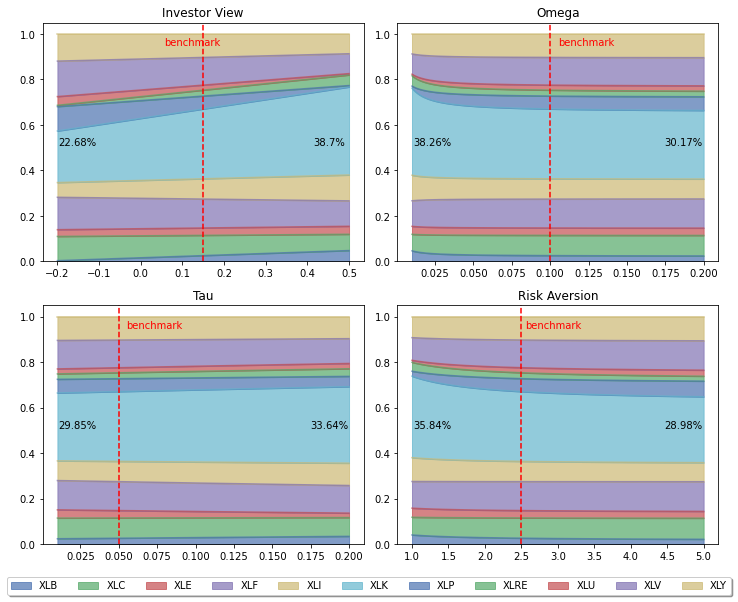

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

#Investor View
output = pd.DataFrame()

for i in np.linspace(-.2, 0.5, 201):
    P = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0, -0.5, 0, -0.5, 0, 0]])
    Q = np.array([[i],[0.03]])
    Omega = np.array([[0.1,0],[0,0.15]])
    tau = 0.05
    Risk_Aversion = 2.5
    Cov_Matrix = data.cov()*12
    mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]
    a = BL_model(mcap_weights,Cov_Matrix,Risk_Aversion,P,Q,tau,Omega)
    ef = EfficientFrontier(a, Cov_Matrix, weight_bounds=(None, None))
    output = pd.concat([output, pd.DataFrame(list(ef.max_quadratic_utility(risk_aversion=Risk_Aversion).values())).transpose()], ignore_index=True)
output = output.set_axis(data.columns, axis=1)
output = output.set_axis(np.linspace(-0.2, 0.5, 201), axis=0)

output.plot(kind='area', stacked=True,alpha=0.7, ax=axes[0,0])

axes[0,0].annotate(str(round(output.iloc[0,5]*100,2))+"%", xy=(-.2, 0.5),xytext=(20,0),
            textcoords='offset points', ha='center', va='bottom')
axes[0,0].annotate(str(round(output.iloc[-1,5]*100,2))+"%", xy=(0.5, 0.5),xytext=(-20,0),
            textcoords='offset points', ha='center', va='bottom')

axes[0,0].axvline(x=0.15, color='r', linestyle='--')
axes[0,0].annotate('benchmark', xy=(0.15, 0.95), xytext=(0.055, 0.95), color='r')
axes[0,0].legend().remove()
axes[0,0].set_title("Investor View")


#Omega
output = pd.DataFrame()

for i in np.linspace(0.01, 0.2, 200):
    P = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0, -0.5, 0, -0.5, 0, 0]])
    Q = np.array([[0.15],[0.03]])
    Omega = np.array([[i,0],[0,0.15]])
    tau = 0.05
    Risk_Aversion = 2.5
    Cov_Matrix = data.cov()*12
    mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]
    a = BL_model(mcap_weights,Cov_Matrix,Risk_Aversion,P,Q,tau,Omega)
    ef = EfficientFrontier(a, Cov_Matrix, weight_bounds=(None, None))
    output = pd.concat([output, pd.DataFrame(list(ef.max_quadratic_utility(risk_aversion=Risk_Aversion).values())).transpose()], ignore_index=True)
output = output.set_axis(data.columns, axis=1)
output = output.set_axis(np.linspace(0.01, 0.2, 200), axis=0)
output.plot(kind='area', stacked=True,alpha=0.7, ax=axes[0,1])

axes[0,1].annotate(str(round(output.iloc[0,5]*100,2))+"%", xy=(0.01, 0.5),xytext=(20,0),
            textcoords='offset points', ha='center', va='bottom')
axes[0,1].annotate(str(round(output.iloc[-1,5]*100,2))+"%", xy=(0.2, 0.5),xytext=(-20,0),
            textcoords='offset points', ha='center', va='bottom')

axes[0,1].axvline(x=0.1, color='r', linestyle='--')
axes[0,1].annotate('benchmark', xy=(Implied_Returns[5][0], 0.95), xytext=(0.105, 0.95),color='r')
axes[0,1].legend().remove()
axes[0,1].set_title("Omega")

#tau
output = pd.DataFrame()

for i in np.linspace(0.01, 0.2, 200):
    P = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0, -0.5, 0, -0.5, 0, 0]])
    Q = np.array([[0.15],[0.03]])
    Omega = np.array([[0.1,0],[0,0.15]])
    tau = i
    Risk_Aversion = 2.5
    Cov_Matrix = data.cov()*12
    mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]
    a = BL_model(mcap_weights,Cov_Matrix,Risk_Aversion,P,Q,tau,Omega)
    ef = EfficientFrontier(a, Cov_Matrix, weight_bounds=(None, None))
    output = pd.concat([output, pd.DataFrame(list(ef.max_quadratic_utility(risk_aversion=Risk_Aversion).values())).transpose()], ignore_index=True)
output = output.set_axis(data.columns, axis=1)
output = output.set_axis(np.linspace(0.01, 0.2, 200), axis=0)
output.plot(kind='area', stacked=True,alpha=0.7, ax=axes[1,0])

axes[1,0].annotate(str(round(output.iloc[0,5]*100,2))+"%", xy=(0.01, 0.5),xytext=(20,0),
            textcoords='offset points', ha='center', va='bottom')
axes[1,0].annotate(str(round(output.iloc[-1,5]*100,2))+"%", xy=(0.2, 0.5),xytext=(-20,0),
            textcoords='offset points', ha='center', va='bottom')

axes[1,0].axvline(x=0.05, color='r', linestyle='--')
axes[1,0].annotate('benchmark', xy=(0.05, 0.95), xytext=(0.055, 0.95),color='r')
axes[1,0].set_title("Tau")
axes[1,0].legend().remove()

#Risk Aversion
output = pd.DataFrame()

for i in np.linspace(1, 5, 200):
    P = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0, -0.5, 0, -0.5, 0, 0]])
    Q = np.array([[0.15],[0.03]])
    Omega = np.array([[0.1,0],[0,0.15]])
    tau = 0.05
    Risk_Aversion = i
    Cov_Matrix = data.cov()*12
    mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]
    a = BL_model(mcap_weights,Cov_Matrix,Risk_Aversion,P,Q,tau,Omega)
    ef = EfficientFrontier(a, Cov_Matrix, weight_bounds=(None, None))
    output = pd.concat([output, pd.DataFrame(list(ef.max_quadratic_utility(risk_aversion=Risk_Aversion).values())).transpose()], ignore_index=True)
output = output.set_axis(data.columns, axis=1)
output = output.set_axis(np.linspace(1, 5, 200), axis=0)
output.plot(kind='area', stacked=True,alpha=0.7, ax=axes[1,1])

axes[1,1].annotate(str(round(output.iloc[0,5]*100,2))+"%", xy=(1, 0.5),xytext=(20,0),
            textcoords='offset points', ha='center', va='bottom')
axes[1,1].annotate(str(round(output.iloc[-1,5]*100,2))+"%", xy=(5, 0.5),xytext=(-20,0),
            textcoords='offset points', ha='center', va='bottom')

axes[1,1].axvline(x=2.5, color='r', linestyle='--')
axes[1,1].annotate('benchmark', xy=(2.5, 0.95), xytext=(2.55, 0.95),color='r')

axes[1,1].legend().remove()
axes[1,1].set_title("Risk Aversion")


#legends
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,0), shadow=True, ncol=11)

# Adjust layout
plt.tight_layout()
plt.show()


Results are consistent with previous analysis.

### 4.6. Relative view sensitivity in a combined view

We use the same approach as 4.5. However, we changed the parameters on the relative view instead of the absolute view.

In [20]:
#baseline model for 1 relative and 1 absolute views
P = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0, -0.5, 0, -0.5, 0, 0]])
Q = np.array([[0.15],[0.03]])
Omega = np.array([[0.1,0],[0,0.15]])
tau = 0.05
Risk_Aversion = 2.5
Cov_Matrix = data.cov()*12
mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]

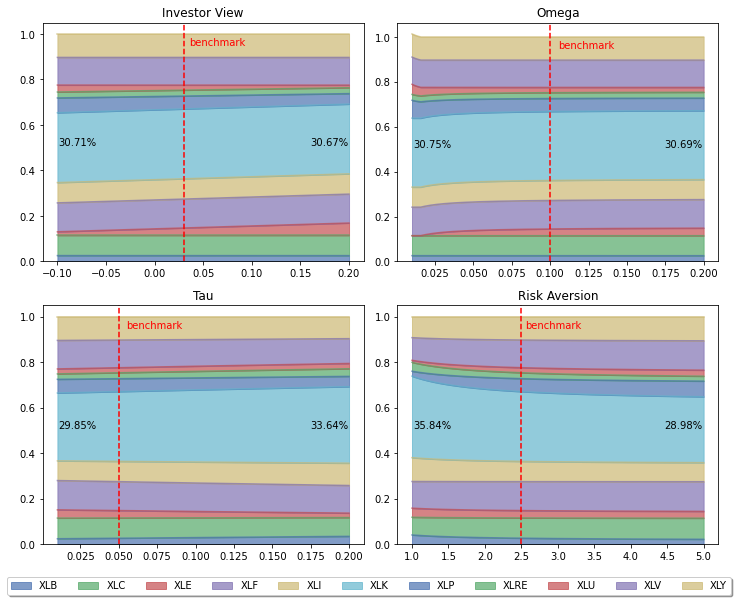

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

#Investor View
output = pd.DataFrame()

for i in np.linspace(-.1, 0.2, 201):
    P = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0, -0.5, 0, -0.5, 0, 0]])
    Q = np.array([[0.15],[i]])
    Omega = np.array([[0.1,0],[0,0.15]])
    tau = 0.05
    Risk_Aversion = 2.5
    Cov_Matrix = data.cov()*12
    mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]
    a = BL_model(mcap_weights,Cov_Matrix,Risk_Aversion,P,Q,tau,Omega)
    ef = EfficientFrontier(a, Cov_Matrix, weight_bounds=(None, None))
    output = pd.concat([output, pd.DataFrame(list(ef.max_quadratic_utility(risk_aversion=Risk_Aversion).values())).transpose()], ignore_index=True)
output = output.set_axis(data.columns, axis=1)
output = output.set_axis(np.linspace(-0.1, 0.2, 201), axis=0)

output.plot(kind='area', stacked=True,alpha=0.7, ax=axes[0,0])

axes[0,0].annotate(str(round(output.iloc[0,5]*100,2))+"%", xy=(-.1, 0.5),xytext=(20,0),
            textcoords='offset points', ha='center', va='bottom')
axes[0,0].annotate(str(round(output.iloc[-1,5]*100,2))+"%", xy=(0.2, 0.5),xytext=(-20,0),
            textcoords='offset points', ha='center', va='bottom')

axes[0,0].axvline(x=0.03, color='r', linestyle='--')
axes[0,0].annotate('benchmark', xy=(0.03, 0.95), xytext=(0.035, 0.95), color='r')
axes[0,0].legend().remove()
axes[0,0].set_title("Investor View")


#Omega
output = pd.DataFrame()

for i in np.linspace(0.01, 0.2, 200):
    P = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0, -0.5, 0, -0.5, 0, 0]])
    Q = np.array([[0.15],[0.03]])
    Omega = np.array([[0.1,0],[0,i]])
    tau = 0.05
    Risk_Aversion = 2.5
    Cov_Matrix = data.cov()*12
    mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]
    a = BL_model(mcap_weights,Cov_Matrix,Risk_Aversion,P,Q,tau,Omega)
    ef = EfficientFrontier(a, Cov_Matrix, weight_bounds=(None, None))
    output = pd.concat([output, pd.DataFrame(list(ef.max_quadratic_utility(risk_aversion=Risk_Aversion).values())).transpose()], ignore_index=True)
output = output.set_axis(data.columns, axis=1)
output = output.set_axis(np.linspace(0.01, 0.2, 200), axis=0)
output = output.clip(lower=0)
output.plot(kind='area', stacked=True,alpha=0.7, ax=axes[0,1])

axes[0,1].annotate(str(round(output.iloc[0,5]*100,2))+"%", xy=(0.01, 0.5),xytext=(20,0),
            textcoords='offset points', ha='center', va='bottom')
axes[0,1].annotate(str(round(output.iloc[-1,5]*100,2))+"%", xy=(0.2, 0.5),xytext=(-20,0),
            textcoords='offset points', ha='center', va='bottom')

axes[0,1].axvline(x=0.1, color='r', linestyle='--')
axes[0,1].annotate('benchmark', xy=(Implied_Returns[5][0], 0.95), xytext=(0.105, 0.95),color='r')
axes[0,1].legend().remove()
axes[0,1].set_title("Omega")

#tau
output = pd.DataFrame()

for i in np.linspace(0.01, 0.2, 200):
    P = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0, -0.5, 0, -0.5, 0, 0]])
    Q = np.array([[0.15],[0.03]])
    Omega = np.array([[0.1,0],[0,0.15]])
    tau = i
    Risk_Aversion = 2.5
    Cov_Matrix = data.cov()*12
    mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]
    a = BL_model(mcap_weights,Cov_Matrix,Risk_Aversion,P,Q,tau,Omega)
    ef = EfficientFrontier(a, Cov_Matrix, weight_bounds=(None, None))
    output = pd.concat([output, pd.DataFrame(list(ef.max_quadratic_utility(risk_aversion=Risk_Aversion).values())).transpose()], ignore_index=True)
output = output.set_axis(data.columns, axis=1)
output = output.set_axis(np.linspace(0.01, 0.2, 200), axis=0)
output.plot(kind='area', stacked=True,alpha=0.7, ax=axes[1,0])

axes[1,0].annotate(str(round(output.iloc[0,5]*100,2))+"%", xy=(0.01, 0.5),xytext=(20,0),
            textcoords='offset points', ha='center', va='bottom')
axes[1,0].annotate(str(round(output.iloc[-1,5]*100,2))+"%", xy=(0.2, 0.5),xytext=(-20,0),
            textcoords='offset points', ha='center', va='bottom')

axes[1,0].axvline(x=0.05, color='r', linestyle='--')
axes[1,0].annotate('benchmark', xy=(0.05, 0.95), xytext=(0.055, 0.95),color='r')
axes[1,0].set_title("Tau")
axes[1,0].legend().remove()

#Risk Aversion
output = pd.DataFrame()

for i in np.linspace(1, 5, 200):
    P = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0, -0.5, 0, -0.5, 0, 0]])
    Q = np.array([[0.15],[0.03]])
    Omega = np.array([[0.1,0],[0,0.15]])
    tau = 0.05
    Risk_Aversion = i
    Cov_Matrix = data.cov()*12
    mcap_weights = [0.0226, 0.0914, 0.0372, 0.1291, 0.0859, 0.2963, 0.0610, 0.0233, 0.0218, 0.1262, 0.1052]
    a = BL_model(mcap_weights,Cov_Matrix,Risk_Aversion,P,Q,tau,Omega)
    ef = EfficientFrontier(a, Cov_Matrix, weight_bounds=(None, None))
    output = pd.concat([output, pd.DataFrame(list(ef.max_quadratic_utility(risk_aversion=Risk_Aversion).values())).transpose()], ignore_index=True)
output = output.set_axis(data.columns, axis=1)
output = output.set_axis(np.linspace(1, 5, 200), axis=0)
output.plot(kind='area', stacked=True,alpha=0.7, ax=axes[1,1])

axes[1,1].annotate(str(round(output.iloc[0,5]*100,2))+"%", xy=(1, 0.5),xytext=(20,0),
            textcoords='offset points', ha='center', va='bottom')
axes[1,1].annotate(str(round(output.iloc[-1,5]*100,2))+"%", xy=(5, 0.5),xytext=(-20,0),
            textcoords='offset points', ha='center', va='bottom')

axes[1,1].axvline(x=2.5, color='r', linestyle='--')
axes[1,1].annotate('benchmark', xy=(2.5, 0.95), xytext=(2.55, 0.95),color='r')

axes[1,1].legend().remove()
axes[1,1].set_title("Risk Aversion")


#legends
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,0), shadow=True, ncol=11)

# Adjust layout
plt.tight_layout()
plt.show()


The results are quite interesting. Even though XLK is not involved in the relative view, its parameters still affect it. This is justified by the correlation of XLK with the assets involved in the relative view is less than 1. The parameters $τ$, and $λ$ has the highest impact on XLK optimal weight.

## 5. Conclusion

In this work, we performed a sensitivity analysis of the BL output based on different view parameters. We showed that the most impactful inputs are low levels of Omega, i.e. more confidence in the views, and the views themselves ($Q$). The Omega is difficult to formulate, as it is harder to define and not apt for qualitative managers (Herold, 2003).

Although the model output can be sensitive to low levels of risk aversion ($λ$), the most used values range from 2 to 3. Friend & Blume (1975) finds the relative risk aversion coefficient to be over 1 and most likely above 2. Other studies evidence numbers closer to 1 (see Hansen & Singleton, 1983; Chetty, 2006). More recently, Gándelman & Hernández-Murillo (2015) note that the most used measurements fall between 1 and 3. Therefore, values where the risk aversion coefficient mostly lies do not affect the BL output too much.

Regarding $t$, although the output is not very sensitive to this parameter, it still needs research as its calculation is abstract and affects all assets, even if they are not involved in any view.

Overall, we suggest further research on the formulation of $τ$ and the Omega matrix.

## 6. References

- Black, F., & Litterman, R. (1990). Asset allocation: combining investor views with market equilibrium. Goldman Sachs Fixed Income Research, 115(1), 7-18.

- Black, F., & Litterman, R. (1991). Global asset allocation with equities, bonds, and currencies. Fixed Income Research, 2(15-28), 1-44.

- Black, F., & Litterman, R. (1992). Global portfolio optimisation. Financial analysts journal, 48(5), 28-43. https://doi.org/10.2469/faj.v48.n5.28

- Fama, E. F. (1970). Efficient Capital Markets: A Review of Theory and Empirical Work. The Journal of Finance, 25(2), 383–417. https://doi.org/10.2307/2325486

- Chetty, R. (2006). A New Method of Estimating Risk Aversion. American Economic Review, 96(5), 1821–1834. https://doi.org/10.1257/aer.96.5.1821

- Friend, I., & Blume, M. E. (1975). The Demand for Risky Assets. The American Economic Review, 65(5), 900–922. http://www.jstor.org/stable/1806628

- Gándelman, N., & Hernández-Murillo, R. (2015). Risk Aversion at the Country Level. Review, 97(1), 53–66. https://doi.org/10.20955/r.2015.53-66

- Hansen, L. P., & Singleton, K. J. (1983). Stochastic Consumption, Risk Aversion, and the Temporal Behavior of Asset Returns. Journal of Political Economy, 91(2), 249–265. https://doi.org/10.1086/261141